In [2]:
%load_ext autoreload
%autoreload 2

import os
import torch
import random

import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt

from diveslowlearnfast.config import Config
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast import load_checkpoint
from diveslowlearnfast.train.helper import get_train_transform, get_test_transform, get_mask_transform, get_base_transform
from diveslowlearnfast.models import SlowFast
from diveslowlearnfast.egl import ExplainerStrategy
from diveslowlearnfast.transforms import KwargsCompose, DeterministicRandomShortSideScale, DeterministicRandomCrop, DeterministicHorizontalFlip, get_deterministic_transform_params

from torchvision.transforms.v2 import Compose, CenterCrop
from pytorchvideo.transforms import ShortSideScale
from PIL import Image

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 4
cfg.DATA.TEST_CROP_SIZE = 224
cfg.DATA.NUM_FRAMES = 128
cfg.EGL.METHOD = 'gradcam'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']

vidnames = ['3qq031609lA_00002']

diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    mask_transform_fn=get_mask_transform(cfg),
    video_ids=vidnames,
    loader_mode='jpg',
    mask_type='segments'
)

device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, './data/dlf_32x128_randaug.pth', optimiser, device)

explainer = ExplainerStrategy.get_explainer(model, cfg, device)

model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



SlowFast(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (pathway1_stem): ResNetBasicStem(
      (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s1_fuse): FuseFastToSlow(
    (conv_f2s): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(8, 1, 1), padding=(3, 0, 0), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [33]:
x, _, _, _, _, m = diving48[0]
x.shape, m.shape

(torch.Size([3, 128, 224, 224]), torch.Size([1, 128, 224, 224]))

In [46]:
inputs = dlf.to_slowfast_inputs(x.unsqueeze(0), cfg.SLOWFAST.ALPHA)
attn_maps, _ = explainer(inputs)
heatmaps = dlf.create_heatmaps(inputs, attn_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')

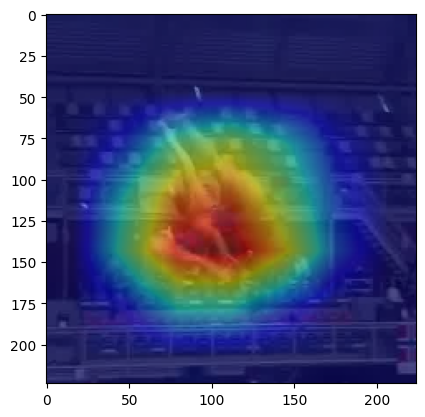

In [47]:
plt.imshow(heatmaps[0][0].permute(1, 2, 3, 0)[12])

In [30]:
slow_heatmap = np.uint8(heatmaps[0][0].permute(1, 2, 3, 0) * 255)
print(slow_heatmap.shape)

for idx, hm in enumerate(slow_heatmap):
    image = Image.fromarray(hm)
    image.save(f'./data/GradCAM/3qq031609lA_00002/slow/{idx:04d}.png')


(16, 224, 224, 3)


In [42]:
m.shape


torch.Size([1, 128, 224, 224])

In [53]:
masks = m.float().expand(3, 128, 224, 224)
masks = np.uint8(masks.permute(1, 2, 3, 0) * 255)

for idx, hm in enumerate(masks):
    image = Image.fromarray(hm)
    image.save(f'./data/DiverMasks/3qq031609lA_00002/{idx:04d}.png')

In [52]:
np.linspace(0, 122, 8, dtype=np.int32)

array([  0,  17,  34,  52,  69,  87, 104, 122], dtype=int32)